In [1]:
import random
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style('darkgrid')

In [2]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq

In [3]:
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [10]:
def make_window_ma(lower = 10, upper = 100):
    """
    Генерация размера скользящего окна, диапазоны указываем в аргументах
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

def make_observing_window(lower = 10, upper = 300):
    """
    Генерация окна наблюдения. То окно, которое будем использовать для обнаружения нестационарности.
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

In [11]:
def get_corr_coef(data, back_steps): #  шаг смещения >= 0
    """
    Calculate correlation coefficient
    :param data: numpy 1D array
    :param back_steps:  autocorrelation shift
    :return: correlation coefficient, float
    """

    return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

def make_autocorrelation_dependence(x, steps_max_part_window = 0.5):
    """
    It takes a numpy array, and the maximum number of steps to calculate the autocorrelation function. The number of steps is expressed in terms of a fraction of the window (the length of the received signal).
    :param x: numpy 1D array
    :param steps_max_part_window: fraction of the array window, default 0.5
    :return: numpy array
    """
    N = int(x.shape[0] * steps_max_part_window)
    steps = range(0, N + 1)
    coefs = [get_corr_coef(x, i) for i in steps]

    return np.array(coefs)

In [12]:
def make_random_signal(length, ma):
    """
    The function creates a smooth signal obtained from noise.
    :param length: size of creating signal
    :param ma: value of moving average window
    :return: nunpy array 1D
    """

    x = np.random.normal(0,1,max(length*2, ma * 2))
    x = pd.Series(x).rolling(window = ma).mean().dropna().values
    abs_x = np.abs(x)
    max_value =abs_x.max()
    x = x/max_value
    x = x[:length]

    return x

In [13]:
def calculate_hulving_time_acf(y, x = None):
    """
    Receive autocorrelation function and return the time it takes to halve
    :param y: numpy 1D array
    :param x: numpy 1D array, steps of shift. If None range(0, y.shape[0])
    :return: float
    """
    for i in range(y.shape[0]):
        if y[i] <= 0.5:
            break
    t2 = i
    t1 = i-1
    y1 = y[t1]
    y2 = y[t2]
    k = (t1 - t2) / (y1 - y2)
    b = t2 - k*y2
    t = k * 0.5 + b
    return t

# Autocorrelation function observing

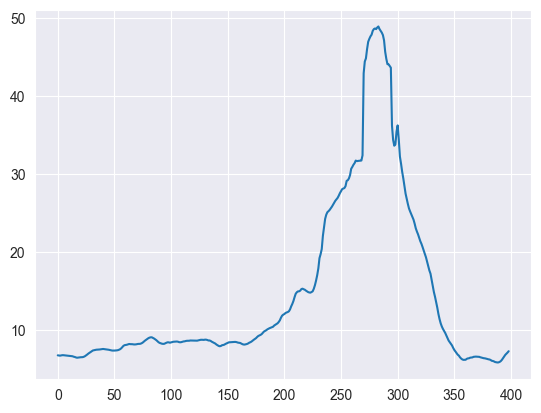

In [27]:
signal = np.concatenate([make_random_signal(300, make_window_ma()), make_random_signal(300, make_window_ma())])
res = []
for i in range(signal.shape[0]-201):
    acf = make_autocorrelation_dependence(signal[i:i+200])
    res.append(calculate_hulving_time_acf(acf))
plt.plot(res)

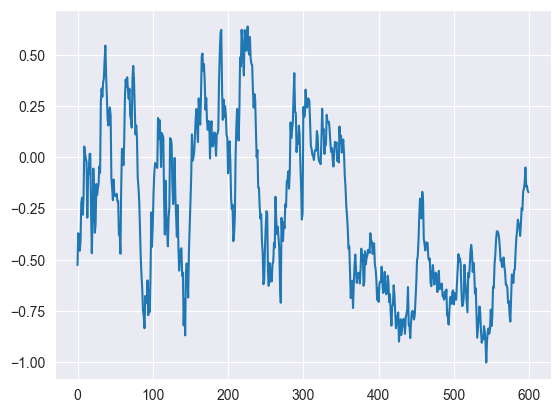

In [28]:
plt.plot(signal)